# Investigation of coalesence for LOW data

Baseline dependent averaging is a form of data coalescence. In this script, we create a critically sampled snapshot of a LOW data set, and then coalesce and decoalesce it to see what errors result. We look at the time required for all steps.

In [4]:
%matplotlib inline

import os
import sys

from time import clock

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['agg.path.chunksize'] = 10000
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.convolution import Gaussian2DKernel, convolve

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 

from arl.data.polarisation import PolarisationFrame
from arl.visibility.operations import create_blockvisibility, vis_summary, copy_visibility
from arl.skycomponent.operations import create_skycomponent, insert_skycomponent, apply_beam_to_skycomponent
from arl.image.operations import show_image, export_image_to_fits, import_image_from_fits, qa_image, \
    create_image_from_array, copy_image, smooth_image
from arl.imaging.base import create_image_from_visibility, predict_skycomponent_visibility 
from arl.fourier_transforms.fft_support import extract_mid
from arl.visibility.coalesce import coalesce_visibility, decoalesce_visibility
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_beam, \
    create_low_test_image_from_gleam, create_low_test_skycomponents_from_gleam
from arl.imaging import *

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the configuration and fill in the appropriate sampling values

In [5]:
config = 'core'
if config == 'full':
    low = create_named_configuration('LOWBD2')
    b = 8e4
    cellsize = 0.00001
    npixel=8192
    nsnapshots = 30

else:
    low = create_named_configuration('LOWBD2-CORE')
    b = 4e3
    cellsize = 0.001
    npixel=512
    nsnapshots = 300

    
oversampling = 32

sampling_time = 35.0 / (oversampling * b)
log.info("Critical sampling time = %.5f (radians) %.2f (seconds)" % 
         (sampling_time, sampling_time * 43200.0 / numpy.pi))
sampling_frequency = 1e8 * 35.0 / (oversampling * b) 
log.info("Critical sampling frequency = %.5f (Hz) " % (sampling_frequency))
times = numpy.arange(0.0, + nsnapshots * sampling_time, sampling_time)
frequency = numpy.linspace(1e8 - sampling_frequency, 1e8 + sampling_frequency, 3)
channel_bandwidth = numpy.full_like(frequency, sampling_frequency)

log.info("Observing frequencies %s Hz" % (frequency))

log.info("Cellsize = %.6f radians" % (cellsize))

Critical sampling time = 0.00027 (radians) 3.76 (seconds)
Critical sampling time = 0.00027 (radians) 3.76 (seconds)
Critical sampling frequency = 27343.75000 (Hz) 
Critical sampling frequency = 27343.75000 (Hz) 
Observing frequencies [  9.99726562e+07   1.00000000e+08   1.00027344e+08] Hz
Observing frequencies [  9.99726562e+07   1.00000000e+08   1.00027344e+08] Hz
Cellsize = 0.001000 radians
Cellsize = 0.001000 radians


We create the visibility holding the vis, uvw, time, antenna1, antenna2, weight columns in a table. The actual visibility values are zero.

In [6]:
phasecentre = SkyCoord(ra=+355.0 * u.deg, dec=-10.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_blockvisibility(low, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))


create_visibility: 300 rows, 0.739 GB
create_visibility: 300 rows, 0.739 GB


Create components from GLEAM 

In [7]:
comps = create_low_test_skycomponents_from_gleam(flux_limit=5.0, polarisation_frame=PolarisationFrame("stokesI"),
                                             frequency=frequency, phasecentre=phasecentre, radius=0.5)

create_low_test_skycomponents_from_gleam: 74 sources above flux limit 5.000
create_low_test_skycomponents_from_gleam: 74 sources above flux limit 5.000


Create the low beam and apply it to the components, only those within the field of view.

In [8]:
model = create_image_from_visibility(vt, npixel=npixel, cellsize=cellsize, frequency=frequency,
                                     polarisation_frame=PolarisationFrame('stokesI'),
                                     phasecentre=phasecentre, nchan=len(frequency))
beam=create_low_test_beam(model)
comps = apply_beam_to_skycomponent(comps, beam)
model = insert_skycomponent(model, comps)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 355., -10.)>, starting frequency 99972656.25 Hz, and bandwidth 27343.75 Hz
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 355., -10.)>, starting frequency 99972656.25 Hz, and bandwidth 27343.75 Hz
create_image_from_visibility: uvmax = 132.219821 wavelengths
create_image_from_visibility: uvmax = 132.219821 wavelengths
create_image_from_visibility: Critical cellsize = 0.003782 radians, 0.216669 degrees
create_image_from_visibility: Critical cellsize = 0.003782 radians, 0.216669 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
import_image_from_fits: created >f4 image 

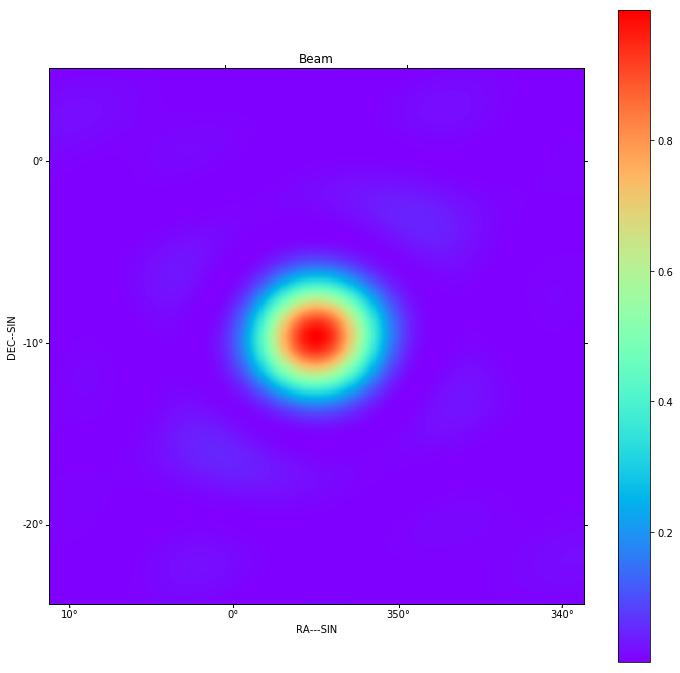

In [9]:
show_image(beam)
plt.title("Beam")
plt.show()

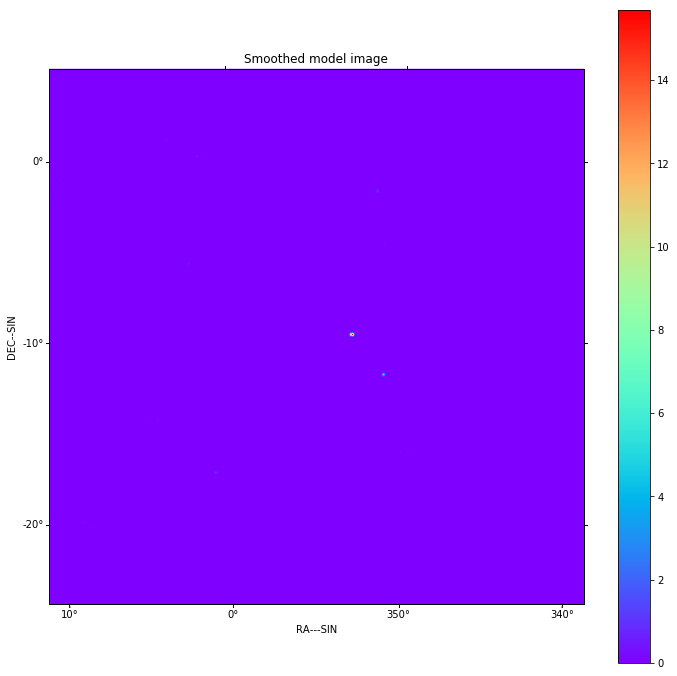

In [10]:
cmodel = smooth_image(model)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Since we are using a BlockVisibility, we can only predict the visibility from sky components. 

In [11]:
vt = predict_skycomponent_blockvisibility(vt, comps)

Now we coalesce the data

coalesce_visibility: Created new Visibility for coalesced data, coalescence factors (t,f) = (1.000,0.000)
coalesce_visibility: Created new Visibility for coalesced data, coalescence factors (t,f) = (1.000,0.000)
coalesce_visibility: Maximum coalescence (t,f) = (100, 100)
coalesce_visibility: Maximum coalescence (t,f) = (100, 100)
coalesce_visibility: Original 300 rows, 0.739 GB, coalesced 12806592 rows, 1.240 GB
coalesce_visibility: Original 300 rows, 0.739 GB, coalesced 12806592 rows, 1.240 GB


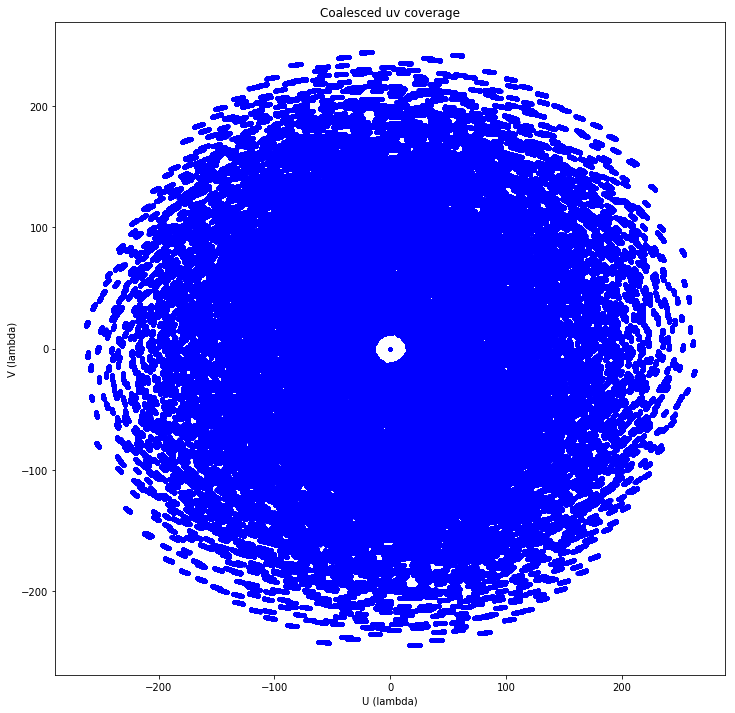

In [12]:
time_coal=1.0
max_time_coal=100
frequency_coal=0.0
max_frequency_coal=1


cvt = coalesce_visibility(vt, time_coal=time_coal, frequency_coal=frequency_coal)
plt.clf()
plt.plot(+cvt.uvw[:,0],+cvt.uvw[:,1], '.', color='b')
plt.plot(-cvt.uvw[:,0],-cvt.uvw[:,1], '.', color='b')
plt.title('Coalesced uv coverage')
plt.xlabel('U (lambda)')
plt.ylabel('V (lambda)')
plt.show()

Check that we did not coalesce in frequency and that we did in time

In [13]:
numpy.unique(cvt.frequency)==vt.frequency

array([ True,  True,  True], dtype=bool)

In [14]:
numpy.unique(cvt.time).size > vt.time.size

True

Make the dirty image from coalesced data

In [15]:
dirtyimage, sumwt = invert_2d(cvt, model)

invert_2d: inverting using 2d transform
invert_2d: inverting using 2d transform


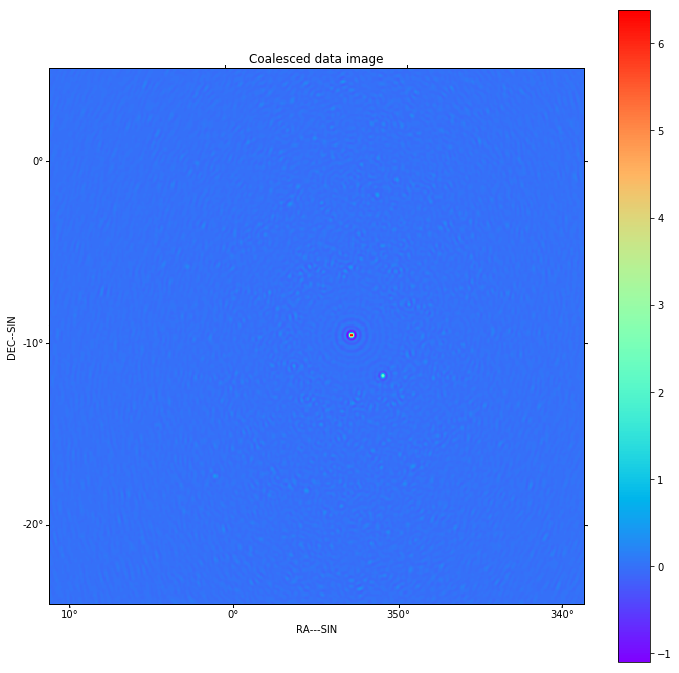

In [16]:
show_image(dirtyimage, cm='rainbow')
plt.title('Coalesced data image')
plt.show()

In [17]:
cvtpred = copy_visibility(cvt, zero=True)
cvtpred.data['vis'][...] = 0.0
cvtpred = predict_skycomponent_visibility(cvtpred, comps)

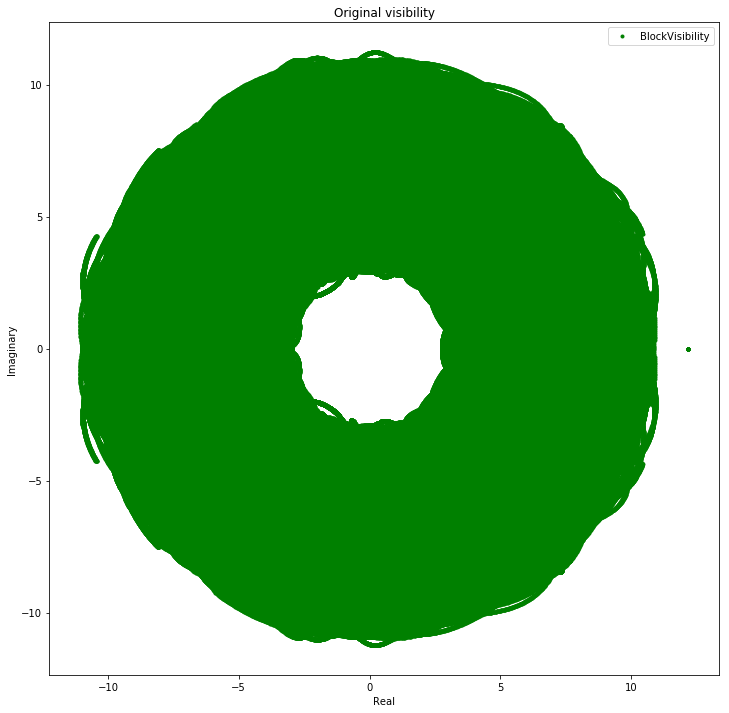

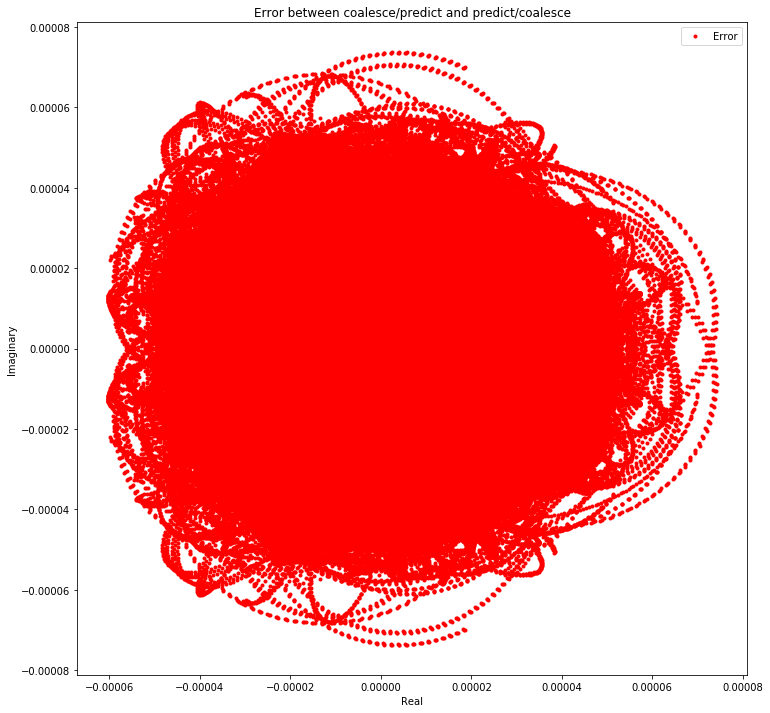

In [18]:
plt.clf()
plt.plot(vt.vis.real.flatten(), vt.vis.imag.flatten(), '.', color='g', label='BlockVisibility')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Original visibility')
plt.legend()
plt.show()

plt.clf()
plt.plot(cvt.vis.real.flatten()-cvtpred.vis.real.flatten(), 
         cvt.vis.imag.flatten()-cvtpred.vis.imag.flatten(), '.', color='r', label='Error')
plt.title('Error between coalesce/predict and predict/coalesce')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()
plt.show()